## This notebook:

  * Converts the S- and C-band measured luminosities to $L_{1.4GHz}$
  
  
  
  
  * Takes the computed L1.4 to compute SFRs for both Amy and Gordon's samples using equation 13 from Yun et al. 2001
    * $$ SFR [M_{sun}/yr] = (5.9±1.8) * 10^{-22}L_{1.4GHz}[W/Hz] $$
  
  
  
  
  
  * Uses DR7 magnitudes $M_i(z=2)$ to compute SFR from equation 2 of Harris et al. 2016
    * $$ SFR [M_{sun}/yr] = -(29±16)M_i^2 - (1625±825)M_i - (22505±10244) $$
  
  
  
  
  
  * Uses our ICA CIV EQW ($E_C$) to compute SFR from equation 8 of Harris et al. 2016
    * $$ SFR [M_{sun}/yr] = (4205±651)E_C^{-0.5} - (328±98) $$
    
    
    
    
    
  * Then use Amy's "forced photometry" method (measuring the NVSS flux density at the optical location of all 8653 sources belonging to our parent sample) to derive mean/median star-formation predictions for our entire color-selected parent sample
  
  
  
  
  * Note that I'm still putting some finishing touches on the imaging, so theses results aren't quite final (at least the ones that use GTR radio data), but I'll re-run everything once our measurements are finalized.  There's also no account for evolution between the two samples yet

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import richardsplot
from astropy.cosmology import FlatLambdaCDM

In [2]:
#Equations
def L14(nu, f, z, LD):
    #Compute 1.4GHz luminosity [erg/s/Hz] given flux at nu and apply K-correction
    Lobs = (4*np.pi*LD**2*1e-23*f*1e-6) * 1e-7
    nuobs = nu*(1+z)
    return Lobs * (1.4/nuobs)**(-.7)

def L3(nu, f, z, LD):
    #Compute 6GHz luminosity [erg/s/Hz] given flux at nu and apply K-correction
    Lobs = (4*np.pi*LD**2*1e-23*f*1e-6) * 1e-7
    nuobs = nu*(1+z)
    return np.log10(Lobs * (3./nuobs)**(-.7))

def L6(nu, f, z, LD):
    #Compute 6GHz luminosity [erg/s/Hz] given flux at nu and apply K-correction
    Lobs = (4*np.pi*LD**2*1e-23*f*1e-6) * 1e-7
    nuobs = nu*(1+z)
    return np.log10(Lobs * (6./nuobs)**(-.7))

def SFR_L14(L14):
    return 5.9e-22 * L14

def SFR_Mi(Mi):
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [3]:
#Use this cosmology - are we OK with this?
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
#Load in GTR data
df = pd.read_csv("SpringFinalFigs_moreParams.csv")
f3 = df[["peak_flux"]].values.flatten() 
ND = (df[["detection"]].values.flatten()+df[["FIRST"]].values.flatten())==0
D = (df[["detection"]].values.flatten()+df[["FIRST"]].values.flatten())==1
F = (df[["detection"]].values.flatten()+df[["FIRST"]].values.flatten())==2
Mi = df[["MIZ2"]].values.flatten()
eqw = df[["ICA_CIV_EQW"]].values.flatten()
z_gtr = df[["redshift_1"]].values.flatten()
LD_gtr = 3.086e24*cosmo.luminosity_distance(z_gtr).value #in cm
L14_gtr = L14(3., f3, z_gtr, LD_gtr)

#Amy's sample
df2 = pd.read_csv("RQQfigs.csv")
f6 = df2[["Flux"]].values.flatten()
det = df2[["Detection"]].values.flatten()==1
z_amy = df2[["z"]].values.flatten()
LD_amy = 3.086e24*cosmo.luminosity_distance(z_amy).value
L14_amy = L14(6., f6, z_amy, LD_amy)
L6_amy = L6(6., f6, z_amy, LD_amy)

#Kellerman data
df3 = pd.read_csv("KellermanQSOs.csv")
f6kell = df3[["S(6)_t"]].values.flatten()
z_kell = df3[["z"]].values.flatten()
LD_kell = 3.086e24*cosmo.luminosity_distance(z_kell).value
L14_kell = L14(6., f6kell, z_kell, LD_kell)
L6_kell = L6(6., f6kell, z_kell, LD_kell)

---

### 1.4GHz Luminosities

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


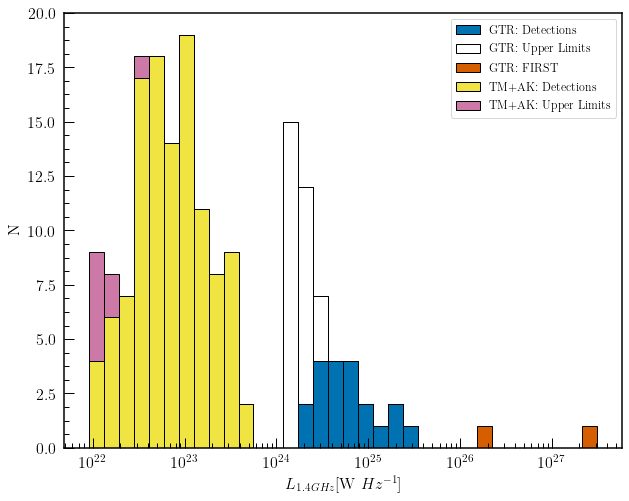

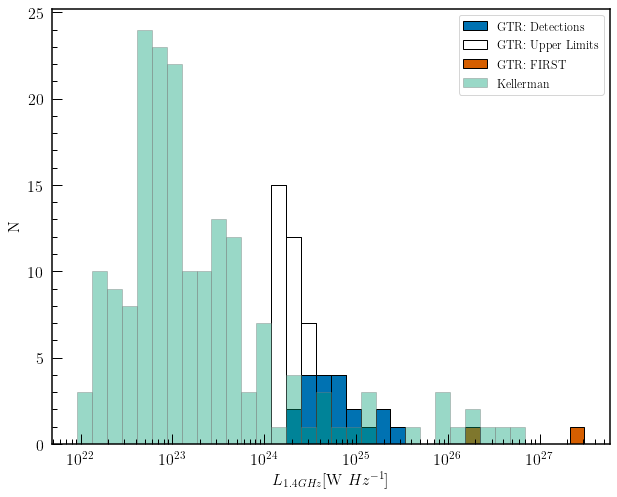

In [5]:
fig = plt.figure(figsize=(10,8))
bins1 = np.logspace(np.log10(min(L14_amy)), np.log10(max(L14_gtr)), 35)

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins1, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
plt.hist([L14_amy[det], L14_amy[~det]], histtype="barstacked", color=["#f0e442", "#cc79a7"], bins=bins1, 
         edgecolor="k", label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.xlabel("$L_{1.4GHz}$[W $Hz^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.ylim(0,20)
plt.legend(loc="best")
plt.show()


fig2 = plt.figure(figsize=(10,8))

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins1, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])

plt.hist([L14_kell], histtype="barstacked", color="#009e73", bins=bins1, label=["Kellerman"],
          alpha=0.4, edgecolor="grey")

plt.xlabel("$L_{1.4GHz}$[W $Hz^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.legend(loc="best")
plt.show()

### Yun SFRs

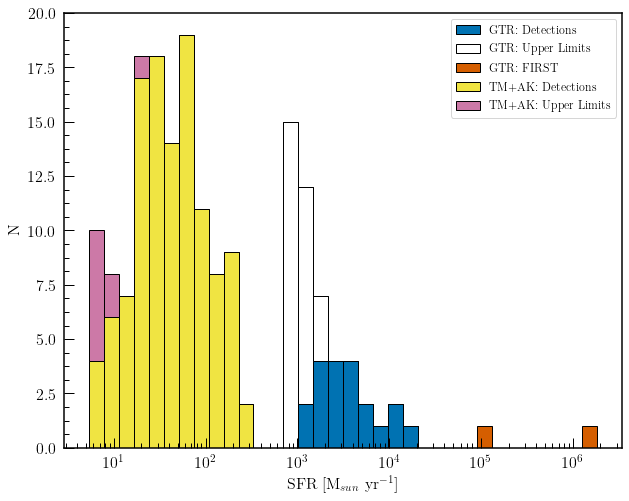

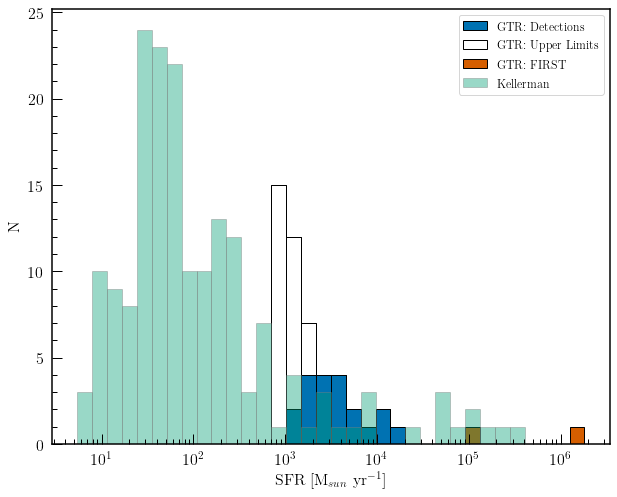

Star formation predictions by Yun et al. 2001:
GTR   median SFR: 1400.89 Msun/yr
AK+TM median SFR: 35.92 Msun/yr
Kell  median SFR: 62.81 Msun/yr


In [6]:
fig = plt.figure(figsize=(10,8))
bins2 = np.logspace(np.log10(min(SFR_L14(L14_amy))), np.log10(max(SFR_L14(L14_gtr))), 35)

plt.hist([SFR_L14(L14_gtr[D]), SFR_L14(L14_gtr[ND]), SFR_L14(L14_gtr[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
plt.hist([SFR_L14(L14_amy[det]), SFR_L14(L14_amy[~det])], histtype="barstacked", color=["#f0e442", "#cc79a7"], 
         edgecolor="k", bins=bins2, label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.ylim(0,20)
plt.legend(loc="best")
plt.show()


fig2 = plt.figure(figsize=(10,8))

plt.hist([SFR_L14(L14_gtr[D]), SFR_L14(L14_gtr[ND]), SFR_L14(L14_gtr[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])

plt.hist(SFR_L14(L14_kell), histtype="barstacked", color="#009e73", label="Kellerman",
          alpha=0.4, bins=bins2, edgecolor="grey")

plt.xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.legend(loc="best")
plt.show()


print("Star formation predictions by Yun et al. 2001:")
print("GTR   median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_gtr))))
print("AK+TM median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_amy))))
print("Kell  median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_kell))))

---

### Other SF calculations

Star formation predictions by Harris et al. 2016:
GTR median SFR (Mi) : 202.33 Msun/yr
GTR median SFR (EQW): 76.73 Msun/yr


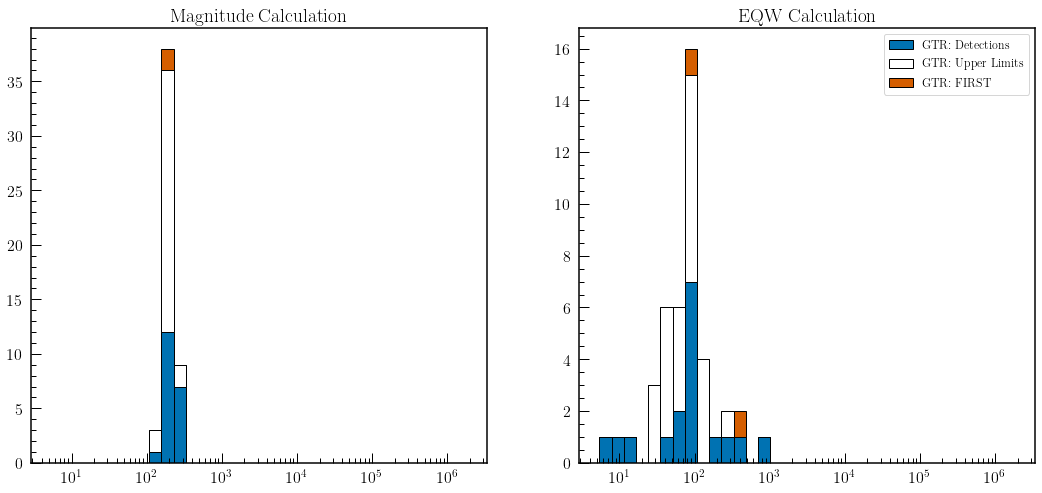

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].hist([SFR_Mi(Mi[D]), SFR_Mi(Mi[ND]), SFR_Mi(Mi[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
ax[0].set_xscale("log")
ax[0].set_title("Magnitude Calculation")

ax[1].hist([SFR_eqw(eqw[D]), SFR_eqw(eqw[ND]), SFR_eqw(eqw[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
ax[1].set_xscale("log")
ax[1].set_title("EQW Calculation")
ax[1].legend(loc="best")

print("Star formation predictions by Harris et al. 2016:")
print("GTR median SFR (Mi) : %.2f Msun/yr" % (np.median(SFR_Mi(Mi))))
print("GTR median SFR (EQW): %.2f Msun/yr" % (np.median(SFR_eqw(eqw))))

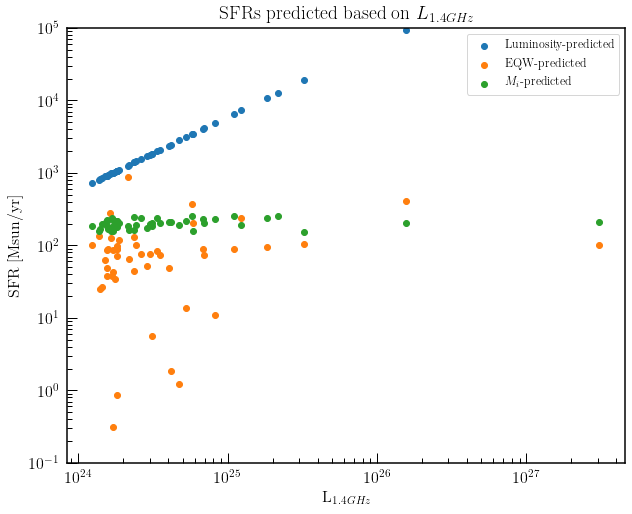

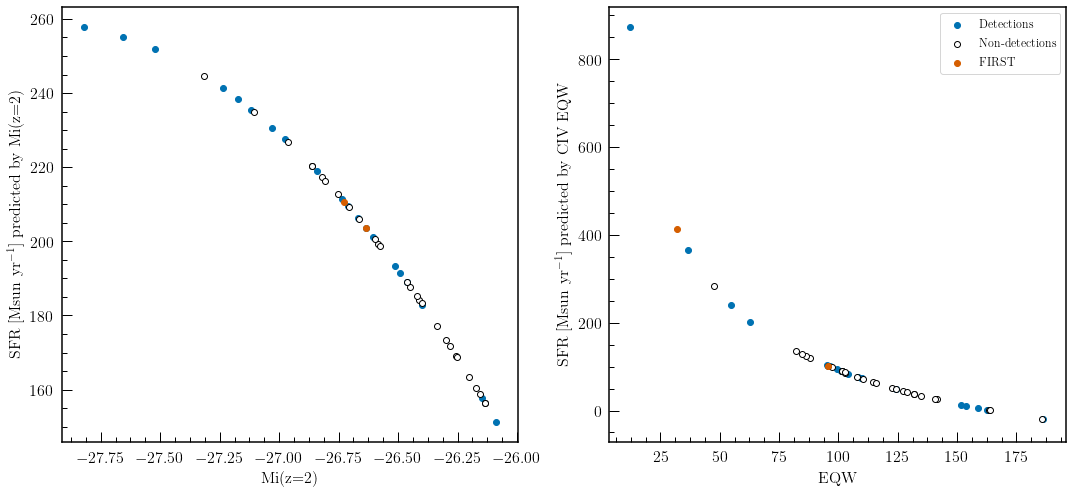

In [8]:
fig1 = plt.figure(figsize=(10,8))
plt.scatter(L14_gtr, SFR_L14(L14_gtr), label="Luminosity-predicted")
plt.scatter(L14_gtr, SFR_eqw(eqw), label="EQW-predicted")
plt.scatter(L14_gtr, SFR_Mi(Mi), label="$M_{i}$-predicted")
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1, 10**5)
plt.xlabel("L$_{1.4GHz}$")
plt.ylabel("SFR [Msun/yr]")
plt.title("SFRs predicted based on $L_{1.4GHz}$")
plt.legend(loc="best")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].scatter(Mi[D], SFR_Mi(Mi[D]), color="#0072b2", label="Detections")
ax[0].scatter(Mi[ND], SFR_Mi(Mi[ND]), color="w", edgecolor="k", label="Non-detections")
ax[0].scatter(Mi[F], SFR_Mi(Mi[F]), color="#d55e00", label="FIRST")

ax[0].set_xlabel("Mi(z=2)")
ax[0].set_ylabel("SFR [Msun yr$^{-1}$] predicted by Mi(z=2)")

ax[1].scatter(eqw[D], SFR_eqw(eqw[D]), color="#0072b2", label="Detections")
ax[1].scatter(eqw[ND], SFR_eqw(eqw[ND]), color="w", edgecolor="k", label="Non-detections")
ax[1].scatter(eqw[F], SFR_eqw(eqw[F]), color="#d55e00", label="FIRST")

ax[1].set_xlabel("EQW")
ax[1].set_ylabel("SFR [Msun yr$^{-1}$] predicted by CIV EQW")
#ax[1].set_xscale("log")
ax[1].legend(loc="best")
plt.show()

Can use these values to re-compute luminosities through SFR predictions:

  $$ L_{1.4}  =  1.7*10^{21} \dot{M}_s $$

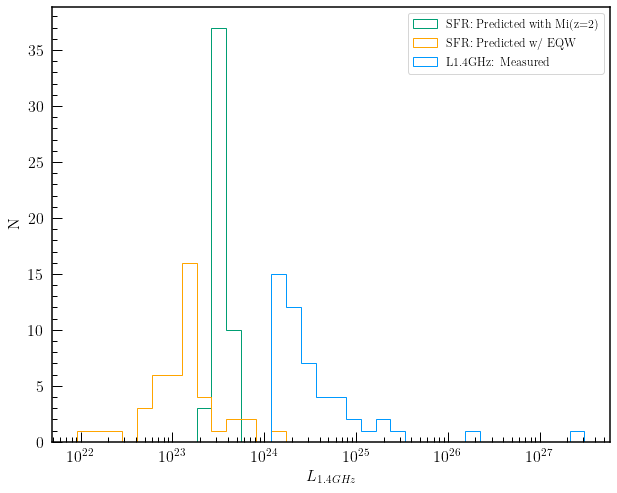

In [9]:
#Use Yun+2001 to invert these SFRs to L1.4GHz
L14_eqw = 1.7e21*SFR_eqw(eqw)
L14_Mi = 1.7e21*SFR_Mi(Mi)

fig = plt.figure(figsize=(10,8))
plt.hist([L14_gtr, L14_eqw, L14_Mi], histtype="step", bins=bins1, color=["#0099ff", "#ffa500", "#009e73"],
          label=["L1.4GHz: Measured", "SFR: Predicted w/ EQW", "SFR: Predicted with Mi(z=2)"])
plt.xscale("log")
plt.xlabel("$L_{1.4GHz}$")
plt.ylabel("N")
plt.legend(loc="best")
plt.show()

So, the SFRs calculated with our optical magnitudes seem to roughly agree with the ~300Msol/yr mean SFR derived for z$\sim$2 in Harris+16, but neither equation from that really agrees with Yun et al. 2001 at all.

Per section 6.4 of Yun et al. (preceding equation 13):
"The integrated 1.4 GHz luminosity density derived from the IRAS 2 Jy sample for L1.4GHz<=10^24 W Hz is 2.6 * 10^19 W Hz-1 Mpc-1 (see Fig. 14). The empirical conversion relation that links this 1.4 GHz luminosity density to the local star formation density of 0.015 ^ 0.005 M_sol yr-1 is then [equation 13]"

--> Our targets too luminous in the radio to apply this equation, so it makes sense that the two papers don't really agree with each other.  Equation built around low-redshift QSOs below the expected "knee" of the RLF at 10^24W/Hz(so may actually prove very useful for mine and Amy's sample)

---

### Forced photometry with NVSS on our N=8653 color-selected parent sample; what is the mean/median star formation rate predicted by this?

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Fit Results:
Mean   = 0.1389 mJy/b
Median = 0.1100 mJy/b
Std    = 0.5734 mJy/b


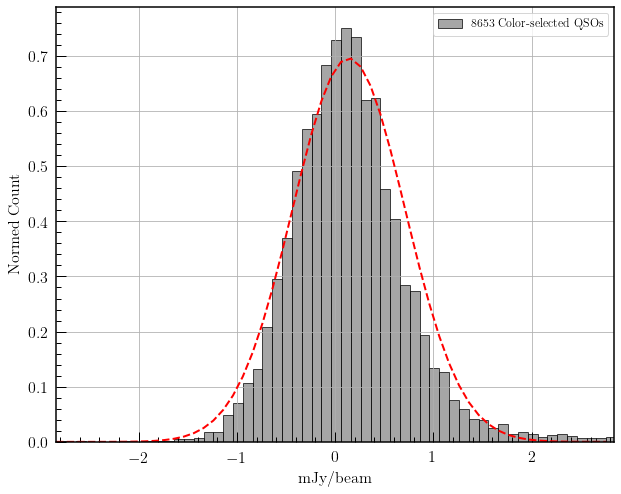

In [10]:
pf = 1e-3*f3 #convert GTR flux from µJy to mJy
pixels = 1000.*(pd.read_csv("forced_photometry.csv").values.flatten()) #values in Jy - want mJy

pixbins=np.arange(min(pixels), max(pixels), .1)

fig = plt.figure(figsize=(10,8))
plt.hist(pixels, color="grey", edgecolor="k", density=True, bins=pixbins, alpha=0.7, label="8653 Color-selected QSOs")
plt.xlim(min(pixels), abs(min(pixels)))
plt.xlabel("mJy/beam")
plt.ylabel("Normed Count")
plt.legend(loc="best")
plt.grid(True)

# best fit of data
(mu, sigma) = norm.fit(pixels[pixels<abs(min(pixels))])
median = np.median(pixels[pixels<abs(min(pixels))])


# add a 'best fit' line
y = mlab.normpdf(pixbins[pixbins<=abs(min(pixels))], mu, sigma)
l = plt.plot(pixbins[pixbins<=abs(min(pixels))], y, 'r--', linewidth=2)

print("Fit Results:")
print("Mean   = %.4f mJy/b" % (mu))
print("Median = %.4f mJy/b" % (median))
print("Std    = %.4f mJy/b" % (sigma))

Note that I only performed the fit on the selected window of data; this distribution actually has a very long tail extending to $\sim$3200mJy/beam and can't be reasonably fit on its own.  Important to also note that these quasars are not all z=1.6, but $1.6 \leq z \leq 2.1$.  In computing mean/median luminosities/SFRs below, I use the midpoint z=1.85 to calculate distances and K-correction

There is a strong positive offset from zero here, which is good.  We can use the above information as a means to calculate mean/median SFRs for our sample -- although calculations above suggest that the equation from Yun et al. 2001 that uses $L_{1.4GHz}$   is not very agreeable with our data.

In [11]:
#Even though equation 13 doesn't seem like it's working too well, see how it does here
meanL14 = L14(1.4, mu*1e3, 1.85, 3.086e24*cosmo.luminosity_distance(1.85).value)
medianL14 = L14(1.4, median*1e3, 1.85, 3.086e24*cosmo.luminosity_distance(1.85).value)

meanSFR = SFR_L14(meanL14)
medianSFR = SFR_L14(medianL14)

print("Predicted mean SFR   = %.4f Msun/yr" % (meanSFR))
print("Predicted median SFR = %.4f Msun/yr" % (medianSFR))

Predicted mean SFR   = 4073.2639 Msun/yr
Predicted median SFR = 3224.8680 Msun/yr


Interesting how this overshoots the predicted SFR derived straight from using the median flux from the GTR sample (given that GTR is just a subsample of the above).  Although I guess it makes sense since our subsample is at lower redshift.

---

### L vs. z

In [12]:
gtrlimit = np.median(df[["RMS"]].values.flatten()[ND])
amylimit = np.median(df2[["RMS"]].values.flatten())

z = np.linspace(min(z_amy), max(z_gtr), 100)
Lz_gtr = np.log10(4*np.pi*(3.086e24*cosmo.luminosity_distance(z).value)**2*(gtrlimit*10**-29) / ((1+z)**(1+-.7))) - 7
Lz_amy = np.log10(4*np.pi*(3.086e24*cosmo.luminosity_distance(z).value)**2*(amylimit*10**-29) / ((1+z)**(1+-.7))) - 7

In [13]:
gtrlimit, amylimit

(9.3, 6.7)

Text(0, 0.5, 'logL [W/Hz]')

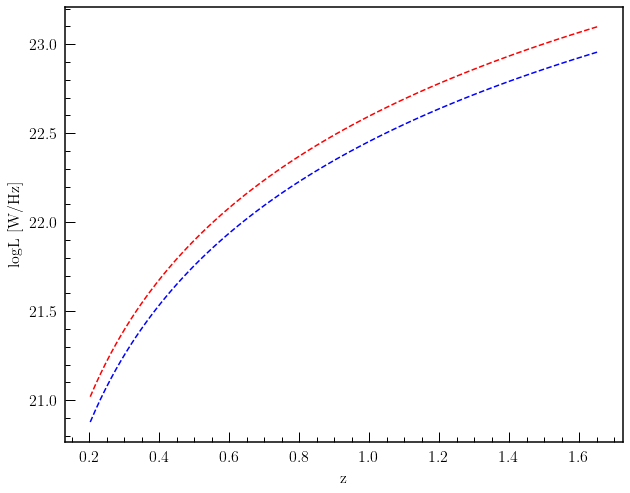

In [14]:
fig = plt.figure(figsize=(10,8))


plt.plot(z, Lz_gtr, '--r')
plt.plot(z, Lz_amy, '--b')
plt.xlabel("z")
plt.ylabel("logL [W/Hz]")

---

$$ T_B = \frac{I_{\nu}c^2}{2k\nu^2} $$

In [15]:
#Angular scale at z~.25 is 3.91kpc/", distance is ~1260Mpc
#Beamwidth for natural weight in A-config ~.495"
solidangle = (3.91*.488)**2 / (cosmo.luminosity_distance(z_amy).value*1e3)**2
#solidangle=4.5e-12

#intensity in W/m^2/Hz/sr, PFimfit currently in µJy/beam
Inu = 1e-26 * df2[["PFimfit"]].values.flatten() * 1e-6 / solidangle
c = 3.e8
k = 1.38e-23
nu = df2[["Freq."]].values.flatten() * 1e9

T_B = Inu*c**2 / (2*k*nu**2)

In [16]:
T_B

array([ 17.83313426,  60.72725992, 255.02267903,  63.79567184,
        35.61187439,  14.05003749,  43.68569203,   2.6778795 ,
         9.80647421,  31.7987141 ,  27.52449252,          nan,
        59.8036523 ,  53.18720698,  19.60793709,  12.54315642,
        39.57766409,  16.22820052,  39.43106211,  23.67940527,
                nan, 172.92199344,  43.91359935,   9.97448214,
         8.55218279, 179.90174962,   6.48188447, 142.70072912,
        13.80561512,   8.85457135,  16.34160177,          nan,
        24.3330661 , 160.80253217,  69.86854902,  15.96535695,
         8.33789629,  12.48437755,  14.46201352,  12.76912663,
         8.06431689,  14.4206197 ,  20.32721959,  35.3459439 ,
        41.45400867, 100.08382889,  24.93521384,   9.67888251,
        60.73385609,  20.35160445,          nan,  19.02269422,
        14.44325786, 106.41307123,  12.04584017,  14.38565977,
        12.0418182 ,  12.33422002,  19.36773818, 159.58477806,
       171.3925448 , 125.43937595,  12.30653175,  11.78

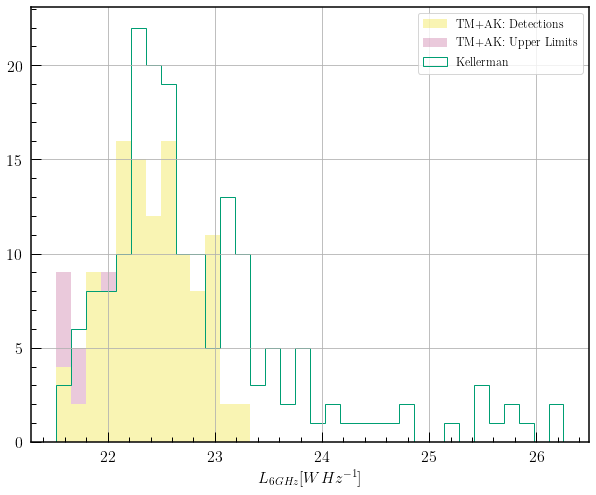

In [17]:
fig = plt.figure(figsize=(10,8))
bins3 = np.linspace(min(L6_amy), max(L6_kell), 35)

plt.hist([L6_amy[det], L6_amy[~det]], histtype="barstacked", color=["#f0e442", "#cc79a7"], 
         alpha=0.4, bins=bins3, label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.hist(L6_kell, histtype="step", color="#009e73", label="Kellerman",
          bins=bins3)

plt.legend(loc="best")
plt.xlabel("$L_{6GHz} [W Hz^{-1}]$")
plt.grid(True)


In [18]:
#Define median Harris SFRs
eqwSFR = np.median(SFR_eqw(eqw)) #median SFR predicted from EQW relation in Harris+2016
MiSFR = np.median(SFR_Mi(Mi))    #median SFR predicted from Mi relation in Harris+2017

#Reverse-engineer Yun+01 to compute theoretical luminosity predicted by SFR calculations
L_eqwSFR_14 = 1.7e21 * eqwSFR * 1e7 #erg/s/Hz; 1.4GHz - convert to S-band
L_eqwSFR = L_eqwSFR_14 * (3./1.4)**(-.7)

#Convert this luminosity (10x fainter) 
f_eqwlimit = 1e6*1e23*((L_eqwSFR)*(1+1.65)**-0.3 / \
                            (4*np.pi*(cosmo.luminosity_distance(1.65).value*3.086e24)**2))

print("EQW relation from Harris+16 tells us our median SFR is %.2f Msol/yr" % eqwSFR)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (np.log10(L_eqwSFR)-7))
print("This gives a spectral flux density of ~ %.2f muJy/b" % f_eqwlimit)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b\n" % (f_eqwlimit/3))


#Do the same thing for the Mi calculation
L_MiSFR_14 = 1.7e21 * MiSFR * 1e7 #erg/s/Hz; 1.4GHz - convert to S-band
L_MiSFR = L_MiSFR_14 * (3./1.4)**(-.7)
f_Milimit = 1e6*1e23*((L_MiSFR)*(1+1.65)**-0.3 / \
                          (4*np.pi*(cosmo.luminosity_distance(1.65).value*3.086e24)**2))

print("Mi relation from Harris+16 tells us our median SFR is %.2f Msol/yr" % MiSFR)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (np.log10(L_MiSFR)-7))
print("This gives a spectral flux density of ~ %.2f muJy/b" % f_Milimit)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b\n" % (f_Milimit/3))



#Harris actually calcualted the mean SFR for z~2 to be 300±100Msol/yr;
#What are the expected needed sensitivities for this?
L14_harris = 1.7e21 * 300 * 1e7 #erg/s/Hz; 1.4GHz - convert to S-band
L_harris = L14_harris * (3./1.4)**(-.7)
flimit_harris = 1e6*1e23*((L_harris)*(1+1.65)**-0.3 / \
                          (4*np.pi*(cosmo.luminosity_distance(1.65).value*3.086e24)**2))

print("For z~2, Harris+16 tells us the median SFR is %.2f Msol/yr" % 300.)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (np.log10(L_harris)-7))
print("This gives a spectral flux density of ~ %.2f muJy/b" % flimit_harris)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b\n" % (flimit_harris/3))


L14_harrisup = 1.7e21 * 400 * 1e7 #erg/s/Hz; 1.4GHz - convert to S-band
L_harrisup = L14_harrisup * (3./1.4)**(-.7)
flimit_harrisup = 1e6*1e23*((L_harrisup)*(1+1.65)**-0.3 / \
                          (4*np.pi*(cosmo.luminosity_distance(1.65).value*3.086e24)**2))

print("For z~2, Harris+16 tells us the upper-bound median SFR is %.2f Msol/yr" % 400.)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (np.log10(L_harrisup)-7))
print("This gives a spectral flux density of ~ %.2f muJy/b" % flimit_harrisup)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b" % (flimit_harrisup/3))

EQW relation from Harris+16 tells us our median SFR is 76.73 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 22.88
This gives a spectral flux density of ~ 3.17 muJy/b
A 3-sigma detection then corresponds to noise levels ~ 1.06muJy/b

Mi relation from Harris+16 tells us our median SFR is 202.33 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 23.30
This gives a spectral flux density of ~ 8.36 muJy/b
A 3-sigma detection then corresponds to noise levels ~ 2.79muJy/b

For z~2, Harris+16 tells us the median SFR is 300.00 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 23.48
This gives a spectral flux density of ~ 12.39 muJy/b
A 3-sigma detection then corresponds to noise levels ~ 4.13muJy/b

For z~2, Harris+16 tells us the upper-bound median SFR is 400.00 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 23.60
This gives a spectral flux density of ~ 16.53 muJy/b
A 3-sigma detection then corresponds to n